In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
test_brain_file = open('../src/val_files.txt')
test_brain_strings = test_brain_file.readlines()
test_brain_strings = [x.strip() for x in test_brain_strings]
n_batches = len(test_brain_strings)
good_labels = sio.loadmat('../data/labels.mat')['labels'][0]

model_name = 'mi_inverted_reg1'
iter_num = 25000
n_test = 10

gpu_id = 3

In [6]:
gpu = '/gpu:' + str(gpu_id)
#     print(gpu)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

vol_size=(160,192,224)

# Anatomical labels we want to evaluate
labels = sio.loadmat('../data/labels.mat')['labels'][0]

atlas = np.load('../data/atlas_norm.npz')
atlas_vol = atlas['vol']
atlas_seg = atlas['seg']
atlas_vol = np.reshape(atlas_vol, (1,)+atlas_vol.shape+(1,))

xx = np.arange(vol_size[1])
yy = np.arange(vol_size[0])
zz = np.arange(vol_size[2])
grid = np.rollaxis(np.array(np.meshgrid(xx, yy, zz)), 0, 4)

images = []
for step in range(0, n_test):
    vol_name, seg_name = test_brain_strings[step].split(",")
    X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
    images.append([X_vol, X_seg])
    
sz = atlas_seg.shape
z_inp1 = tf.placeholder(tf.float32, sz)
z_inp2 = tf.placeholder(tf.float32, sz)
z_out = losses.kdice(z_inp1, z_inp2, good_labels)
kdice_fn = K.function([z_inp1, z_inp2], [z_out])

nn_trf_model = networks.nn_trf(vol_size)


Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory


In [11]:
def test(model_name, iter_num, gpu_id, n_test, invert_images, max_clip, vol_size=(160,192,224), nf_enc=[16,32,32,32], nf_dec=[32,32,32,32,32,16,16]):
    start_time = time.time()

    
    # load weights of model
    with tf.device(gpu):
        net = networks.unet(vol_size, nf_enc, nf_dec)
        net.load_weights('../models/' + model_name +
                         '/' + str(iter_num) + '.h5')

    dice_means = []
    dice_stds = []
    
    print('model loaded', time.time()-start_time)
    for step in range(0, n_test):

        X_vol, X_seg = images[step]

        if invert_images:
            X_vol = max_clip - X_vol

        with tf.device(gpu):
            pred = net.predict([X_vol, atlas_vol])

            # Warp segments with flow
            warp_seg = nn_trf_model.predict([X_seg, pred[1]])

    #         warp_seg = interpn((yy, xx, zz), X_seg[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)
            vals = np.mean(kdice_fn([warp_seg[0,:,:,:,0], atlas_seg]))
            # print(np.mean(vals), np.std(vals))
            mean = np.mean(vals)
            std = np.std(vals)
            dice_means.append(mean)
            dice_stds.append(std)
#         print(step, mean, std)

    print('tested patients', time.time()-start_time)
    return np.mean(dice_means)

In [11]:
def create_graph(model_name, iter_num, step_size, gpu_id, n_test, invert_images=False, max_clip=0.7):    
    test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas = np.load('../data/atlas_norm.npz')
    atlas_vol = atlas['vol']
    atlas_seg = atlas['seg']
    atlas_vol = np.reshape(atlas_vol, (1,)+atlas_vol.shape+(1,))

    images = []
    for step in range(0, n_test):
        vol_name, seg_name = test_brain_strings[step].split(",")
        X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
        images.append([X_vol, X_seg])

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    nn_trf_model = networks.nn_trf(vol_size)
    
    dices = []
    for i in range(iter_num//step_size + 1):
        print(i)
        start_time = time.time()

        # load weights of model
        with tf.device(gpu):
            net = networks.unet(vol_size, nf_enc, nf_dec)
            net.load_weights('../models/' + model_name +
                             '/' + str(i*step_size) + '.h5')

        print('model loaded', time.time()-start_time)
        dice_means = []

        for step in range(0, n_test):
            X_vol, X_seg = images[step]
            if invert_images:
                X_vol = max_clip - X_vol

            with tf.device(gpu):
                pred = net.predict([X_vol, atlas_vol])
                warp_seg = nn_trf_model.predict([X_seg, pred[1]])
                mean = np.mean(kdice_fn([warp_seg[0,:,:,:,0], atlas_seg]))
                dice_means.append(mean)

        print('tested patients', time.time()-start_time)
        dices.append(np.mean(dice_means))
    return dices

In [13]:
dices = create_graph('mi_inverted_reg1', 25000, 1000, 3, 10, invert_images=True)

Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory
0
model loaded 2.1800625324249268
tested patients 28.887739896774292
1
model loaded 2.365412950515747
tested patients 23.247809886932373
2
model loaded 2.165696859359741
tested patients 22.578071117401123
3
model loaded 2.462891101837158
tested patients 23.461572408676147
4
model loaded 2.874297857284546
tested patients 23.002496480941772
5
model loaded 2.5351145267486572
tested patients 23.382744312286377
6
model loaded 2.214392900466919
tested patients 22.595545291900635
7
model loaded 2.880725145339966
tested patients 23.589504718780518
8
model loaded 3.0526821613311768
tested patients 23.71456789970398
9
model loaded 2.8240880966186523
tested patients 23.372472763061523
10
model loaded 2.937026262283325
tested patients 23.92954659461975
11
model loaded 3.401885986328125
tested patients 23.95422673225403
12
model loaded 3.01810884475708
tested patients 23.713684797286987
13
model loaded 2.977440118789673
tested pati

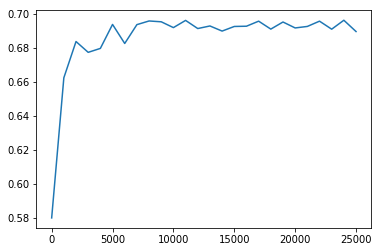

In [18]:
plt.plot(np.linspace(0, 25000, 26), dices)

In [21]:
%%time
dices = []
step_size = 5000
for i in range(25000//step_size + 1):
    print(i)
    dices.append(test(model_name, i*step_size, gpu_id, 10, True, 0.7))

0
1
2
3
4
5
CPU times: user 8min 49s, sys: 1min 10s, total: 10min
Wall time: 6min 28s


In [28]:
%%time
dices_2 = []
step_size = 5000
for i in range(iter_num//step_size + 1):
    print(i)
    dices_2.append(test(model_name, i*step_size, gpu_id, 10, False, 0.7))

0
1
2
3
4
5
6
7
8
CPU times: user 13min 28s, sys: 2min 13s, total: 15min 41s
Wall time: 10min 17s


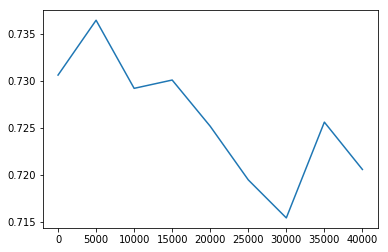

In [30]:
plt.plot([i*step_size for i in range(iter_num//step_size + 1)], dices_2)

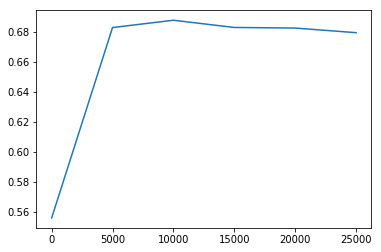

In [31]:
plt.plot([i*step_size for i in range(25000//step_size + 1)], dices)